In [1]:
from shared import graph, stats_utils
from src_draft.utils import LOW_IMP_FEATURES
import shared.ml_config_core as ml_config_core
import pandas as pd
from shared.ml_config_core import ModelConfigsCollection
from shared.ml_config_runner import run_tuning_for_configs_collection
from shared.definitions import TuningResult

from Draft import feature_builder_v2

import importlib
from matplotlib import pyplot as plt
import src_draft.utils as shared_utils
import seaborn as sns

In [2]:
importlib.reload(shared_utils)

shared_utils.pandas_config(pd)
shared_utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

In [3]:
features_matrix = feature_builder_v2.load_datasets_and_prepare_features(drop_meta_data=True,
                                                                        ds_type=feature_builder_v2.DatasetType.FULL)


index SK_BUREAU_ID not found in dataframe, creating new integer column


Appending previous history
Full DS size: 307511


In [4]:
features_matrix_only_high_imp = features_matrix[shared_utils.HIGH_IMP_FEATURES]
features_matrix_any_imp = features_matrix[shared_utils.ANY_IMP_FEATURES]


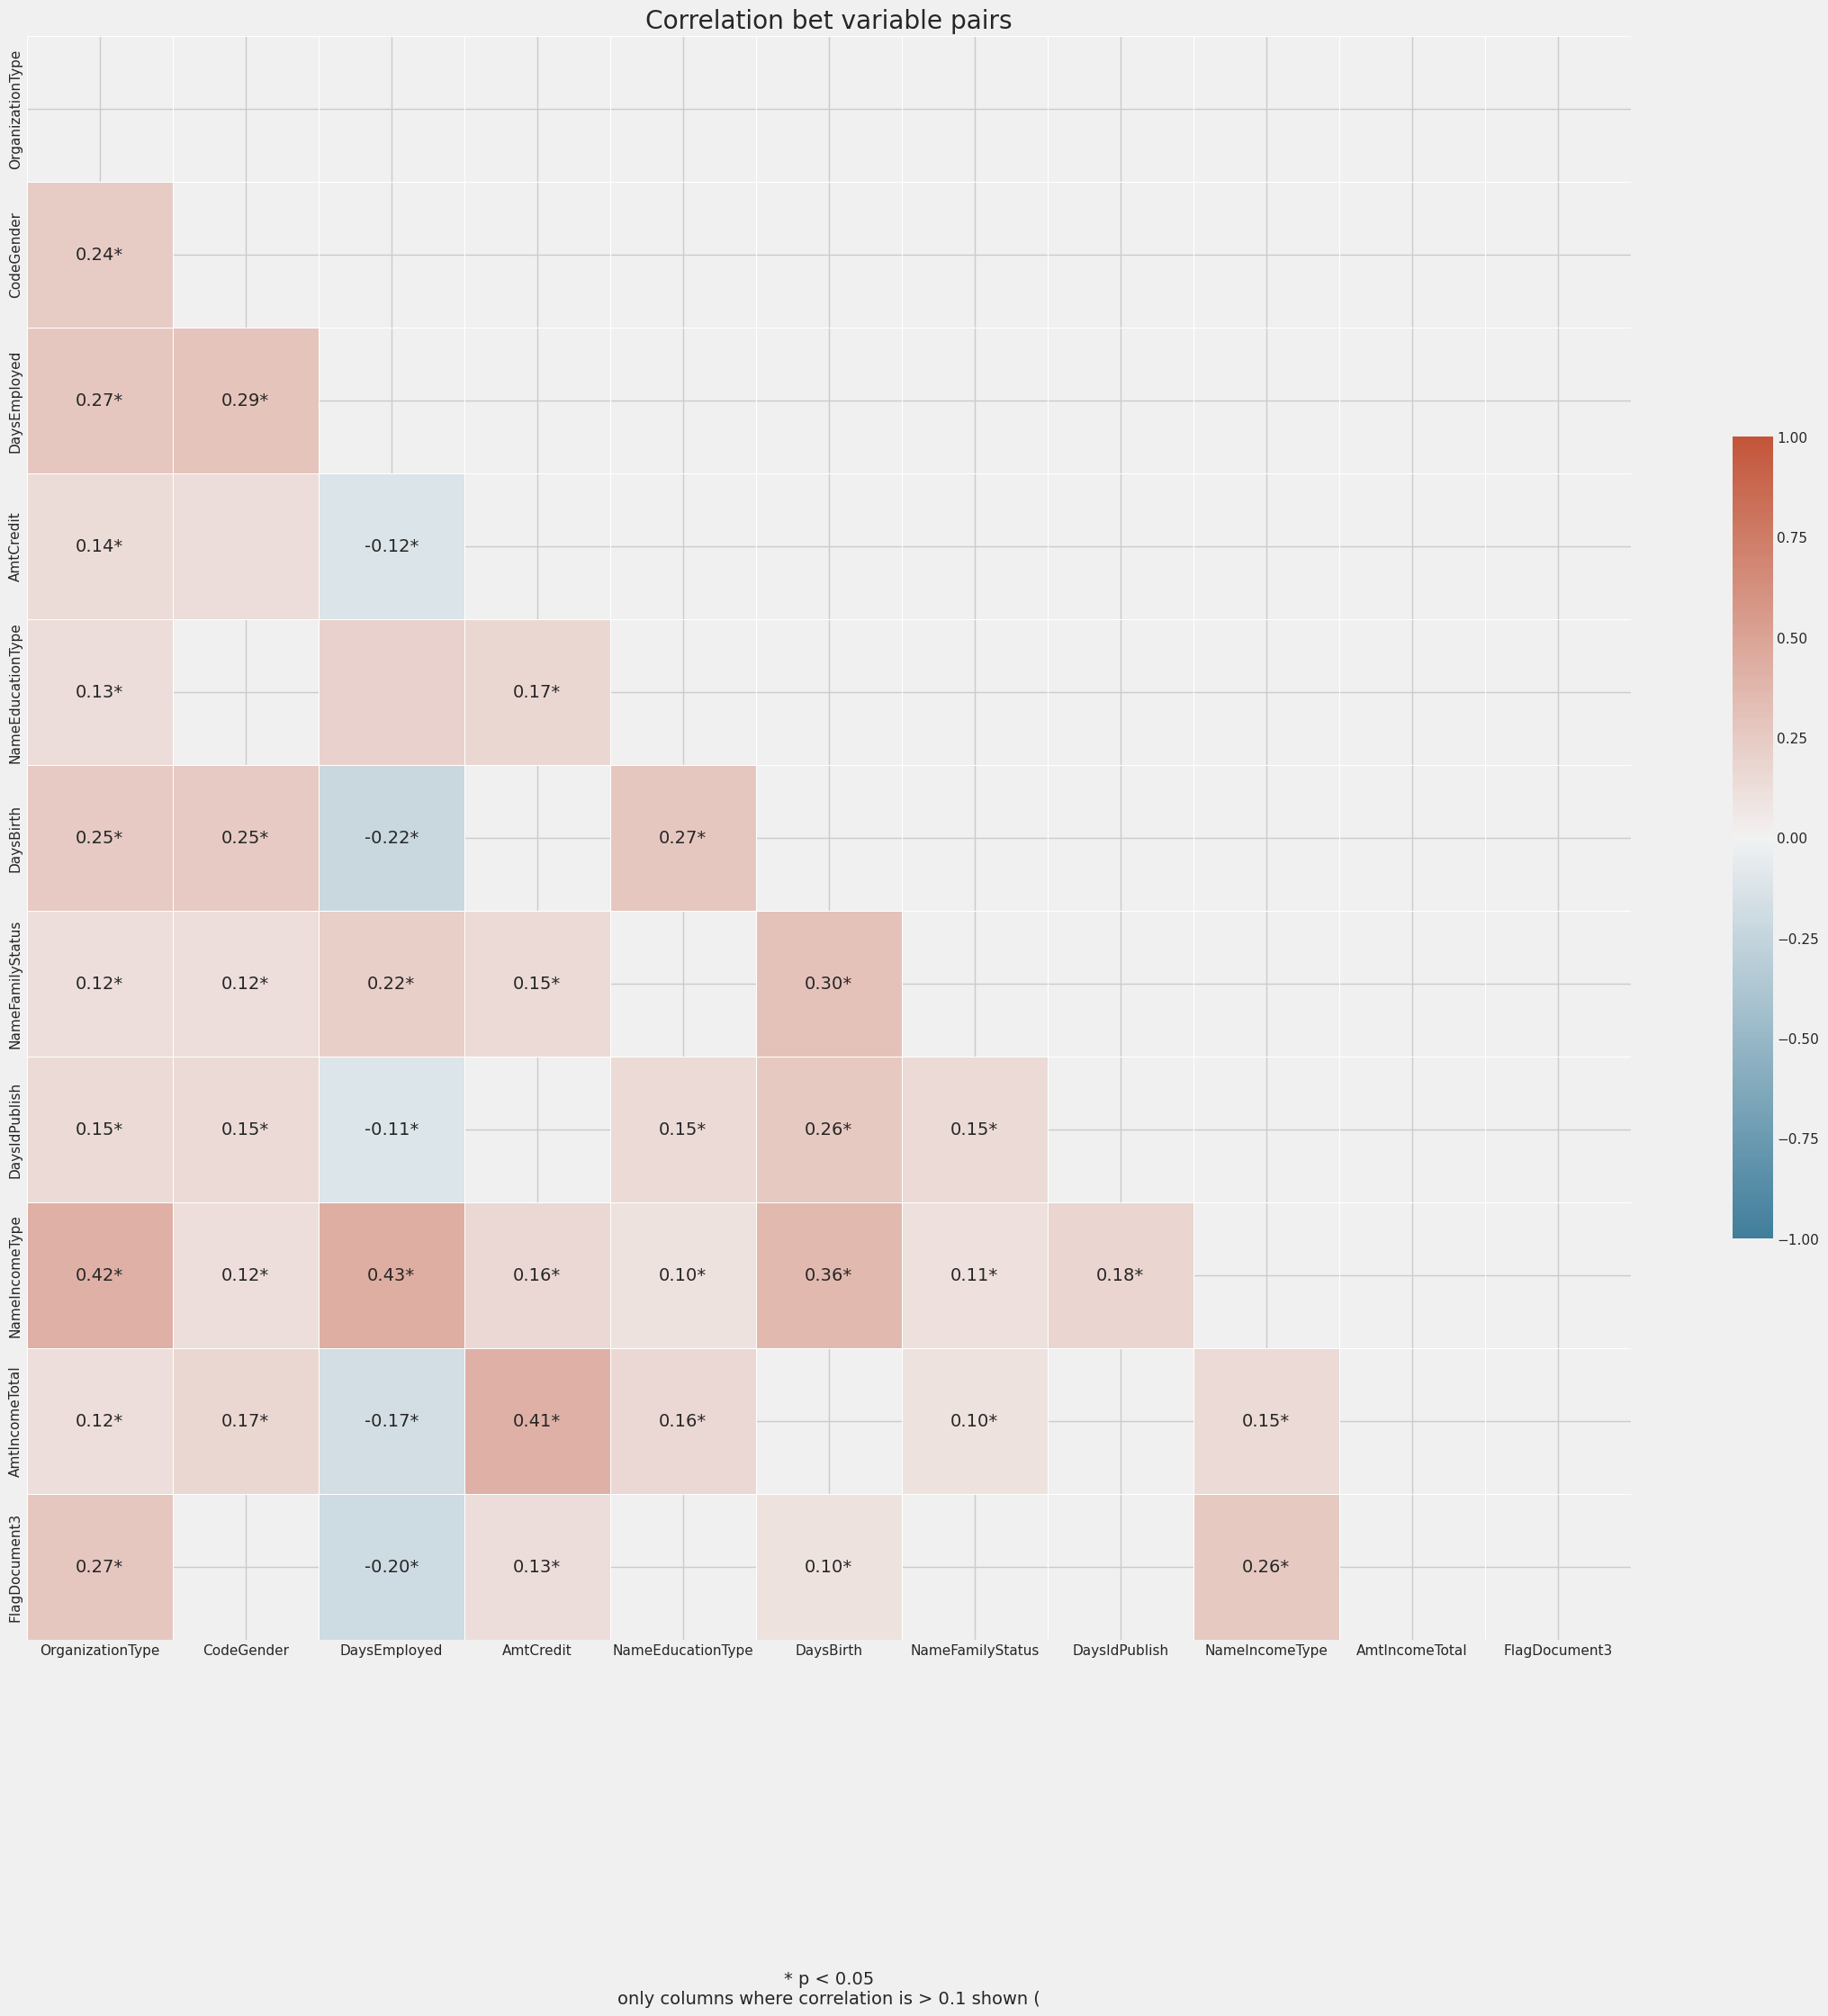

In [5]:
importlib.reload(graph)

graph.render_corr_matrix_based_on_type(features_matrix_only_high_imp.dropna(axis=1, how="any"))
# TODO: 

In [6]:
# features_matrix_only_imp.dtypes

features_matrix_only_imp_cat_cols = features_matrix.select_dtypes(include='category').columns
print(len(features_matrix_only_imp_cat_cols))

22


In [7]:
features_matrix_target_cat = features_matrix.copy()
features_matrix_target_cat["TARGET"] = features_matrix_target_cat["TARGET"].map(lambda x: "Defaulted" if x == 1 else "No Issues")

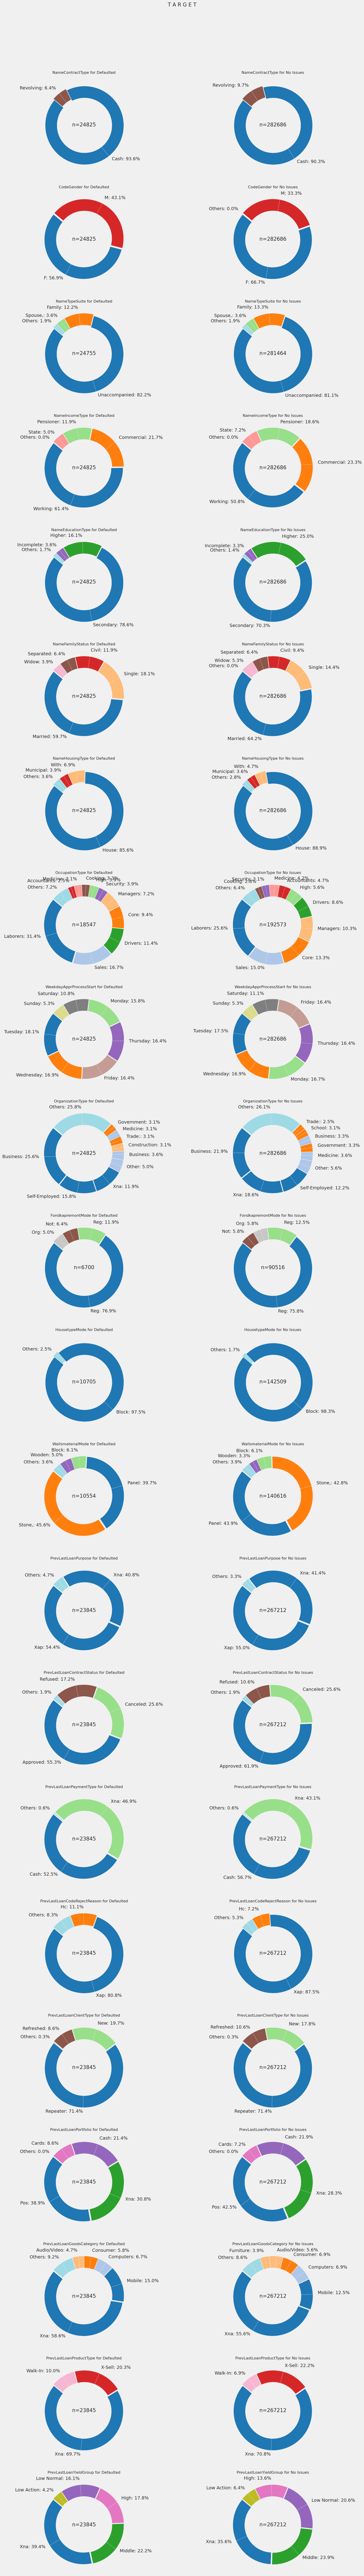

In [8]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_target_cat,
    split_var="TARGET",
    include_cols=features_matrix_only_imp_cat_cols,
)



In [9]:
stats_utils.nan_summary(features_matrix[["ExtSource1", "ExtSource2", "ExtSource3"]])

,Total NaN Values,Proportion NaN (%)
ExtSource1,173378,56.0
ExtSource2,660,0.0
ExtSource3,60965,20.0


In [12]:
features_matrix[["ExtSource1", "ExtSource2", "ExtSource3", "TARGET"]].describe().round(3)

,ExtSource1,ExtSource2,ExtSource3,TARGET
count,134133.000,306851.000,246546.000,307511.000
mean,0.502,0.514,0.511,0.081
std,0.211,0.191,0.195,0.272
min,0.015,0.000,0.001,0.000
25%,0.334,0.392,0.371,0.000
50%,0.506,0.566,0.535,0.000
75%,0.675,0.664,0.669,0.000
max,0.963,0.855,0.896,1.000


In [13]:
features_matrix[["ExtSource1", "ExtSource2", "ExtSource3", "TARGET"]]

,ExtSource1,ExtSource2,ExtSource3,TARGET
0,0.083037,0.262949,0.139376,1
1,0.311267,0.622246,NaN,0
2,NaN,0.555912,0.729567,0
3,NaN,0.650442,NaN,0
4,NaN,0.322738,NaN,0
...,...,...,...,...
307506,0.145570,0.681632,NaN,0
307507,NaN,0.115992,NaN,0
307508,0.744026,0.535722,0.218859,0
307509,NaN,0.514163,0.661024,1


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


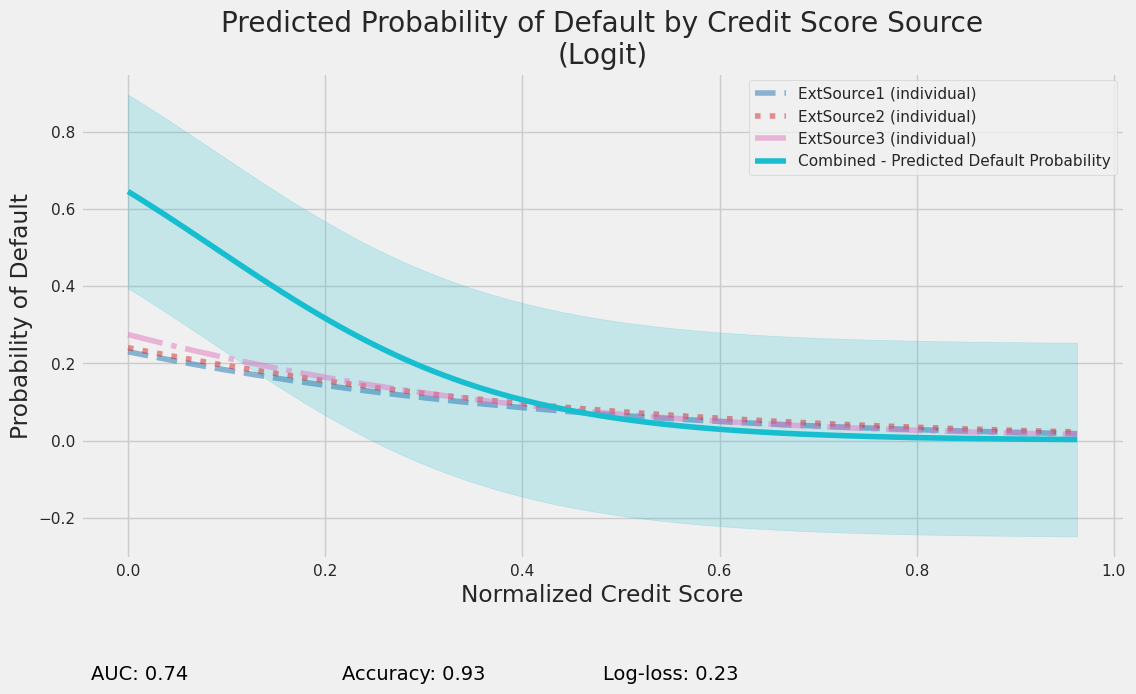

In [85]:
import numpy as np
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss



# Plot setup
plt.figure(figsize=(12, 6))

# Line styles for individual models
line_styles = ['--', ':', '-.']  # Dashed, dotted, dash-dot

# Define X range for all models
x_range = np.linspace(features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3']].min().min(),
                      features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3']].max().max(), 100)

# Initialize lists for storing predictions
predictions = {}

# Plotting colors and styles dynamically
colors = plt.cm.get_cmap('tab10', 4)  # Get 4 distinct colors from the tab10 colormap

# Fit models for individual features
for i, source in enumerate(['ExtSource1', 'ExtSource2', 'ExtSource3']):
    subset = features_matrix[[source, 'TARGET']].dropna()
    X = sm.add_constant(subset[source])
    y = subset['TARGET']
    
    model = sm.Logit(y, X).fit(disp=0)
    X_pred = pd.DataFrame({'const': 1, source: x_range})
    
    y_pred = model.predict(X_pred)
    predictions[source] = y_pred
    
    # Plot individual source predictions
    plt.plot(x_range, y_pred, color=colors(i), linestyle=line_styles[i], alpha=0.5, label=f'{source} (individual)')

# Fit combined model with all features
combined_features = features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3', 'TARGET']].dropna()
X_combined = sm.add_constant(combined_features[['ExtSource1', 'ExtSource2', 'ExtSource3']])
y_combined = combined_features['TARGET']

model_combined = sm.Logit(y_combined, X_combined).fit(disp=0)
X_pred_combined = pd.DataFrame({'const': 1, 'ExtSource1': x_range, 'ExtSource2': x_range, 'ExtSource3': x_range})

y_pred_combined = model_combined.predict(X_pred_combined)
y_pred_combined_for_metrics = model_combined.predict(X_combined)

predictions['Combined'] = y_pred_combined

# Calculate residuals for the combined model
residuals_combined = y_combined - model_combined.predict(X_combined)
residual_std_combined = np.std(residuals_combined)

# Plot combined model prediction with error bars
combined_color = colors(3)  # Selecting the fourth color for the combined model
plt.plot(x_range, y_pred_combined, color=combined_color, label='Combined - Predicted Default Probability')  # Solid line for combined model
plt.fill_between(x_range, y_pred_combined - residual_std_combined, y_pred_combined + residual_std_combined, color=combined_color, alpha=0.2)

auc_combined = roc_auc_score(y_combined, y_pred_combined_for_metrics)
accuracy_combined = accuracy_score(y_combined, y_pred_combined_for_metrics.round())  # Assuming binary classification
logloss_combined = log_loss(y_combined, y_pred_combined_for_metrics)

# Annotations adjusted to use the correct metrics
plt.annotate(f'AUC: {auc_combined:.2f}', xy=(0.01, -0.25), xycoords='axes fraction', fontsize=14, color='black')
plt.annotate(f'Accuracy: {accuracy_combined:.2f}', xy=(0.25, -0.25), xycoords='axes fraction', fontsize=14, color='black')
plt.annotate(f'Log-loss: {logloss_combined:.2f}', xy=(0.50, -0.25), xycoords='axes fraction', fontsize=14, color='black')


# Final plot adjustments
plt.title('Predicted Probability of Default by Credit Score Source\n(Logit)')
plt.xlabel('Normalized Credit Score')
plt.ylabel('Probability of Default')
plt.legend()
plt.show()


In [77]:
features_matrix[labels]


,ExtSource1,ExtSource2,ExtSource3
0,0.083037,0.262949,0.139376
1,0.311267,0.622246,NaN
2,NaN,0.555912,0.729567
3,NaN,0.650442,NaN
4,NaN,0.322738,NaN
...,...,...,...
307506,0.145570,0.681632,NaN
307507,NaN,0.115992,NaN
307508,0.744026,0.535722,0.218859
307509,NaN,0.514163,0.661024


In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
for i in range(1, 2):
    col = f'ExtSource{i}'
    sns.kdeplot(data=features_matrix[features_matrix['TARGET'] == 1][col], label=f'{col} - Default', shade=True)
    sns.kdeplot(data=features_matrix[features_matrix['TARGET'] == 0][col], label=f'{col} - No Default', shade=True)

plt.title('Density Plot of ExtSource Scores by Default Status')
plt.xlabel('Normalized Credit Score')
plt.ylabel('Density')
plt.legend()
plt.show()


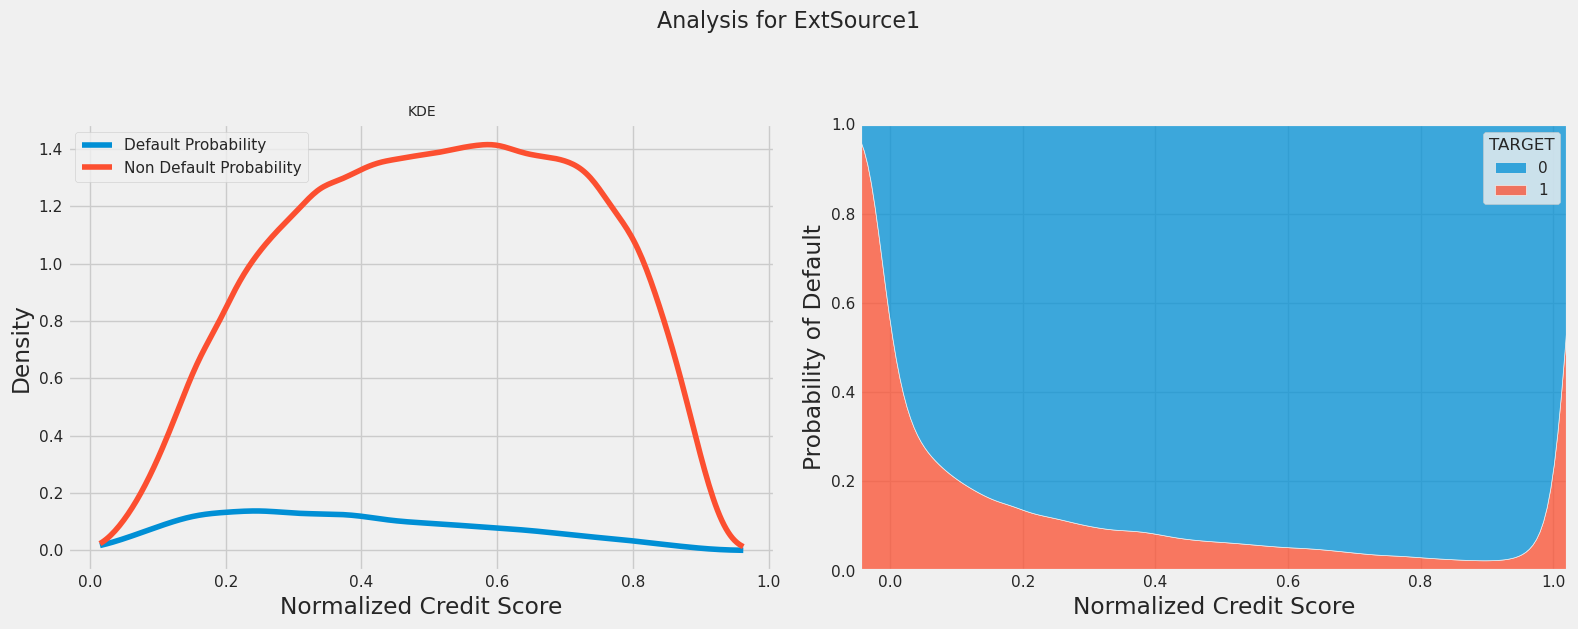

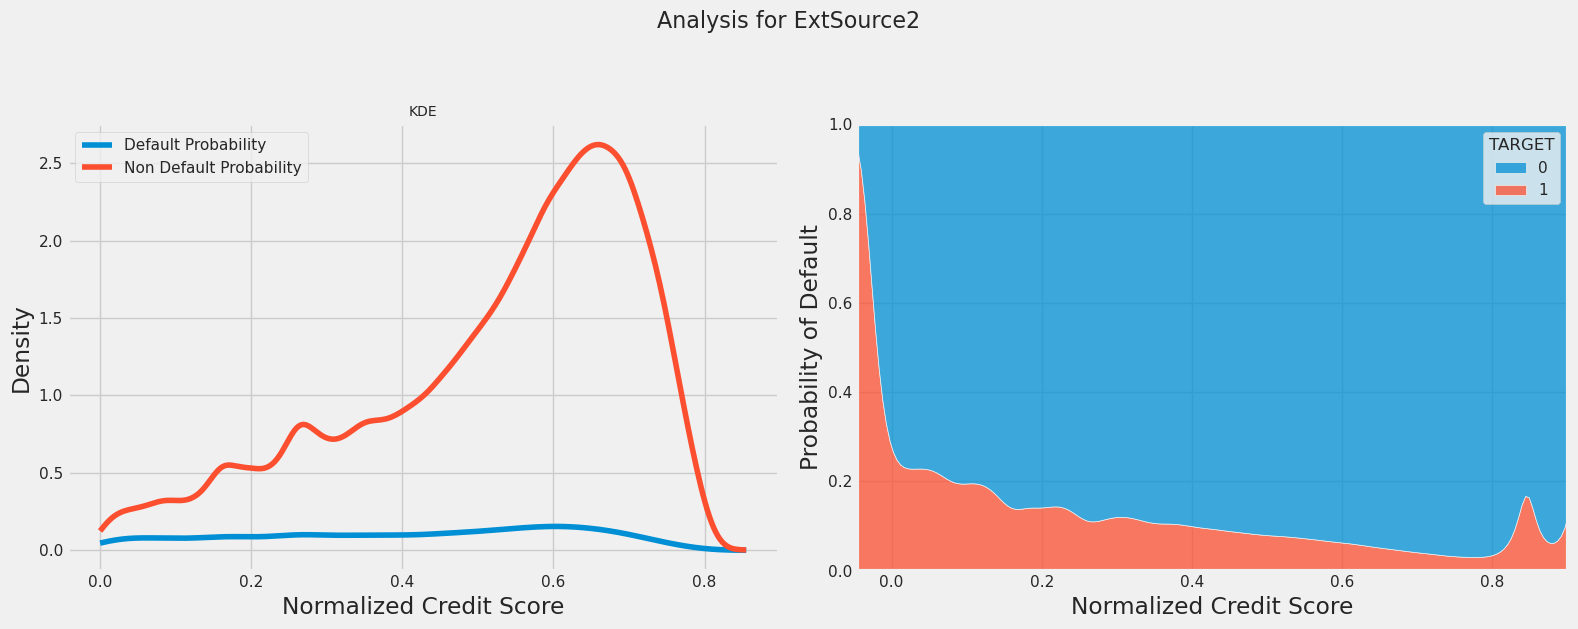

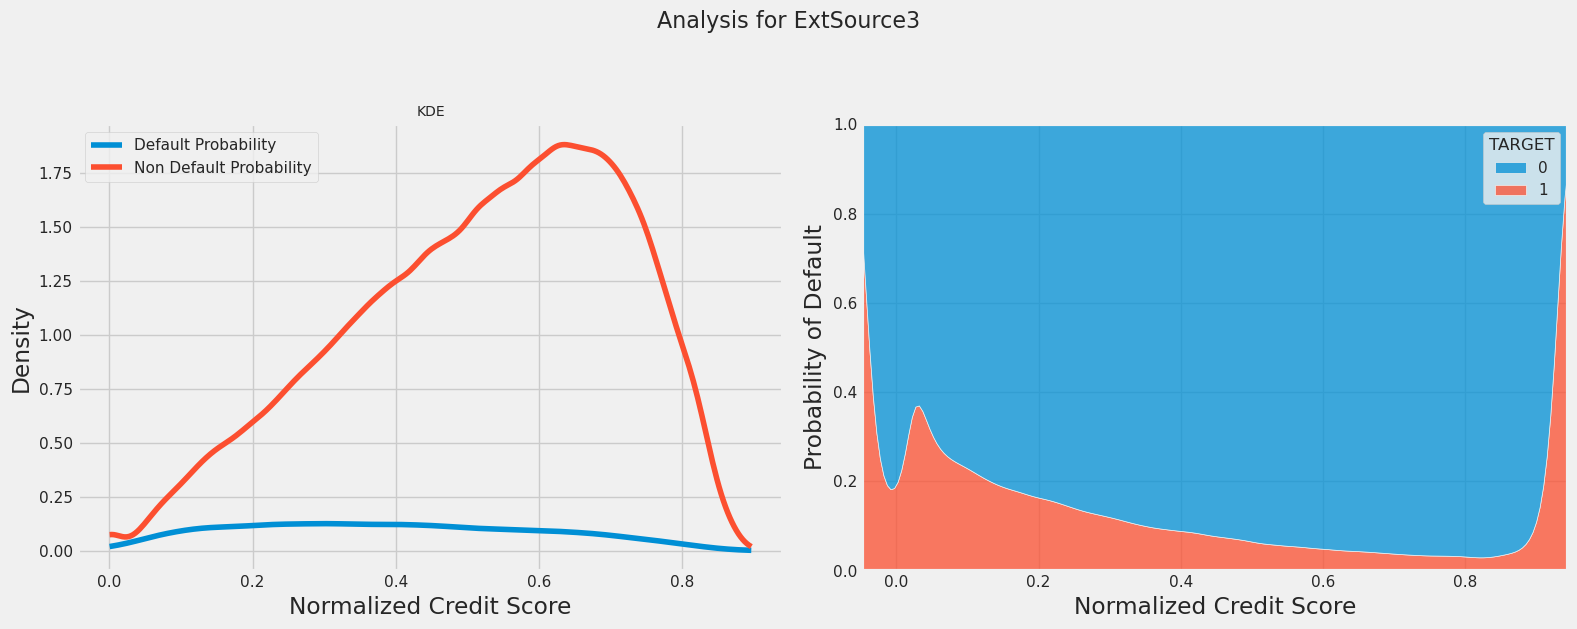

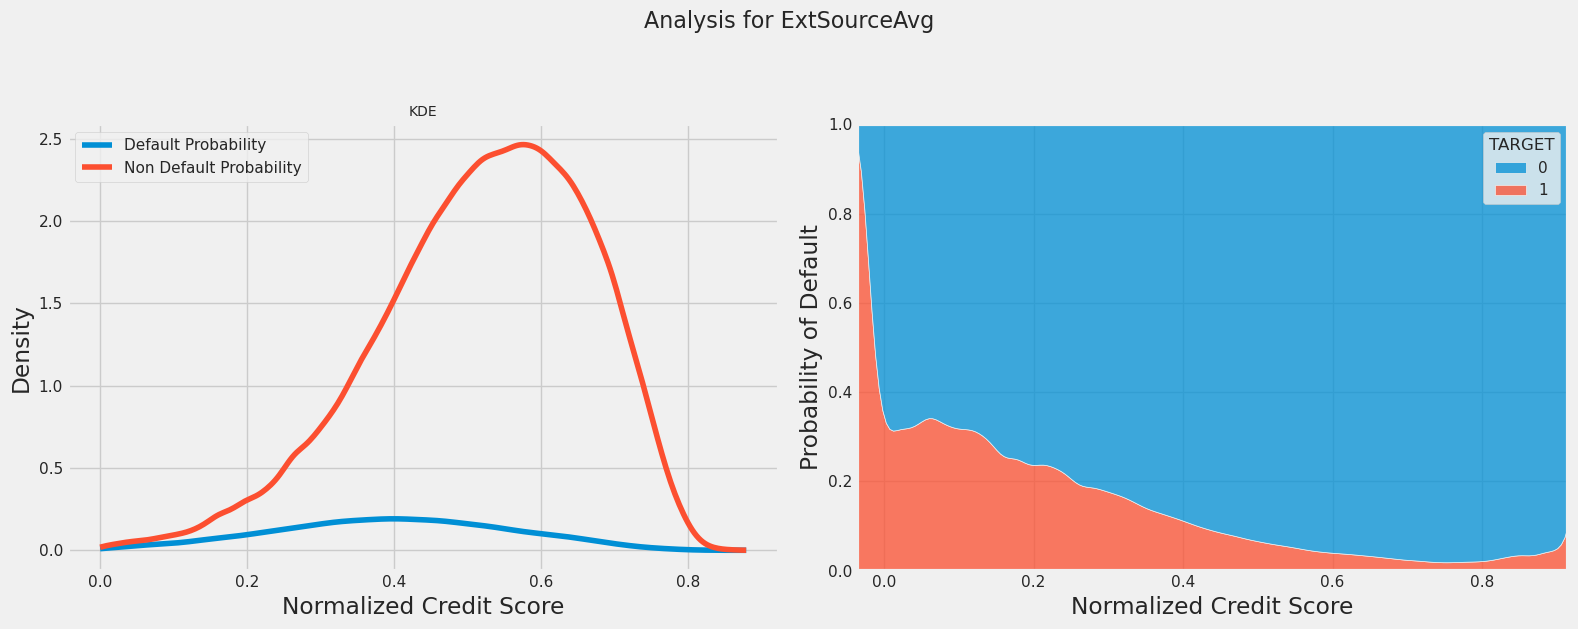

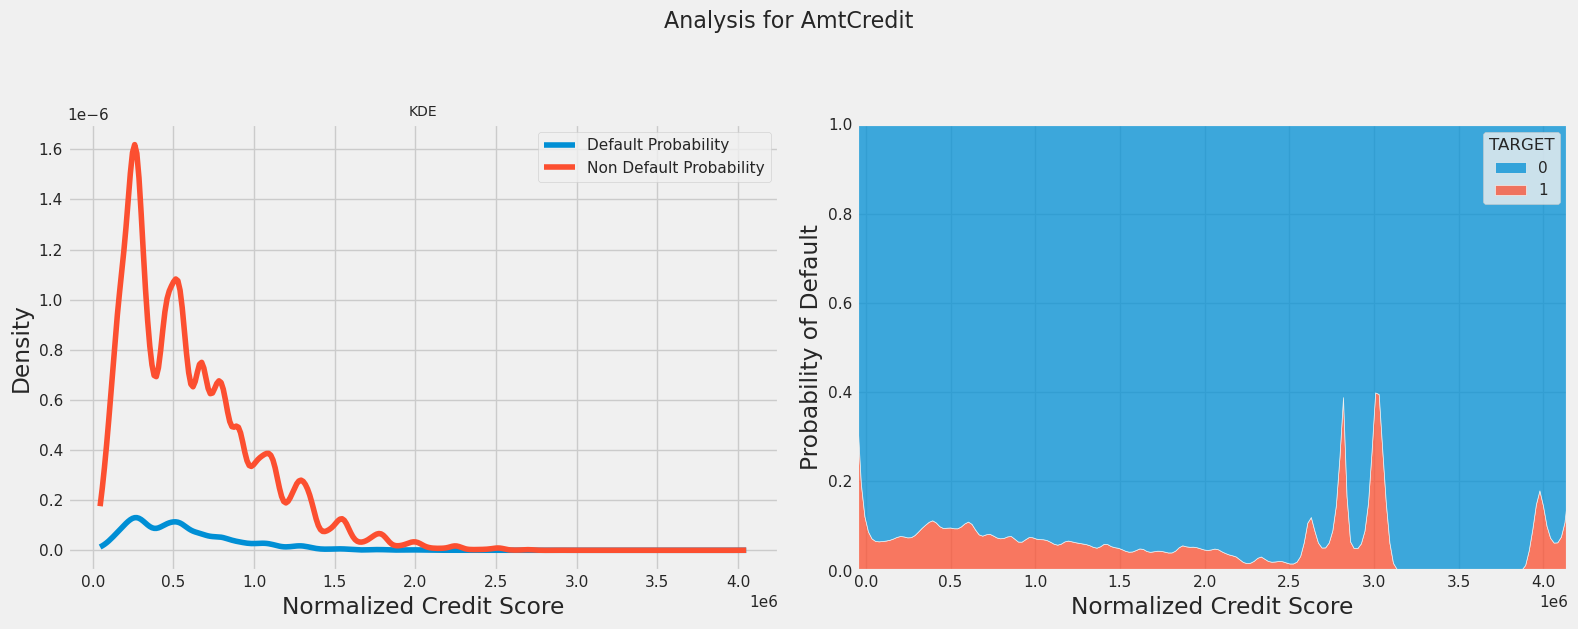

In [59]:
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

df = features_matrix[['ExtSource1', 'ExtSource2', 'ExtSource3', "TARGET", "AmtCredit"]].copy()

# Calculate the average of all ExtSources
df['ExtSourceAvg'] = df[['ExtSource1', 'ExtSource2', 'ExtSource3']].mean(axis=1, skipna=True)

# sources = ['ExtSource1']#, 'ExtSource2', 'ExtSource3', 'ExtSourceAvg']
sources = ['ExtSource1', 'ExtSource2', 'ExtSource3', 'ExtSourceAvg', 'AmtCredit']


for source in sources:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    fig.suptitle(f'Analysis for {source}', fontsize=16, y=1.05)  # Top-level title
    

    # Separate the data
    subset_default = df[df['TARGET'] == 1][source].dropna()
    subset_non_default = df[df['TARGET'] == 0][source].dropna()
    
    # Total number of observations with valid data
    total_count = len(df[source].dropna())
    
    # Define the range for the KDE
    score_range = np.linspace(df[source].min(), df[source].max(), 300)
    
    # KDE for defaults
    kde_default = gaussian_kde(subset_default, bw_method='silverman')
    density_default = kde_default(score_range) * len(subset_default) / total_count
    
    # KDE for non-defaults
    kde_non_default = gaussian_kde(subset_non_default, bw_method='silverman')
    density_non_default = kde_non_default(score_range) * len(subset_non_default) / total_count
    
    # Plotting
    # TODO: add fill with alpha like kde plots
    sns.lineplot(x=score_range, y=density_default, ax=ax1, label='Default Probability')
    sns.lineplot(x=score_range, y=density_non_default, ax=ax1, label='Non Default Probability')

    ax1.set_title(f'KDE', fontsize=10)  # Smaller font size for subplot title
    ax1.set_xlabel('Normalized Credit Score')
    ax1.set_ylabel('Density')
    ax1.legend()

    # Regression Plot
    subset = df[[source, 'TARGET']].dropna()
   
    sns.kdeplot(
        data=subset,
        x=source,
        hue="TARGET",
        # kind="kde",
        # height=6,
        multiple="fill",
        ax=ax2
        # clip=(10, 80),
    )
    # plt.title("Default Rate and EXT_SOURCE_1", x=0.5, y=1.025, fontdict={"size": 16})

    ax2.set_xlabel('Normalized Credit Score')
    ax2.set_ylabel('Probability of Default')
    # ax2.legend()

    # ROC AUC as annotation
    # roc_auc = roc_auc_score(y, model.predict(X))
    # ax2.annotate(f'ROC AUC: {roc_auc:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()


In [60]:
features_matrix_with_bins = features_matrix.copy()
numerical_cols = features_matrix_any_imp.select_dtypes(
    include=["int64", "float64", "Int64"]
).columns

for col in numerical_cols:
    if features_matrix_with_bins[col].nunique() < 5:
        features_matrix_with_bins[f"{col}_binned"] = features_matrix_with_bins[col].astype("category")
    else:
        features_matrix_with_bins[f"{col}_binned"] = stats_utils.bin_and_label(
            features_matrix_with_bins[col], num_bins=4
        )
    features_matrix_with_bins[col] = features_matrix_with_bins[col]


In [61]:
import numpy as np

conditions = [
    features_matrix["PrevRatioRejectedAccepted"].isna(),
    features_matrix["PrevRatioRejectedAccepted"] == 0,
    features_matrix["PrevRatioRejectedAccepted"] <= 0.25,
    features_matrix["PrevRatioRejectedAccepted"] > 0.25
]

choices = ["No Previous App.", 'All Accepted',"< 25% Rejected", "> 25% Rejected"]
# choices = ['All Accepted', "> 0 Rejected"]
# choices = ['No Previous', '0', '> 0']

features_matrix_with_bins["PrevRatioRejectedAccepted_cats"] = np.select(conditions, choices, default='No Previous App')

conditions = [
    features_matrix["TotalDefaults"] == 0,
    features_matrix["TotalDefaults"] >= 1,
    # features_matrix["TotalDefaults"] > 1
]

choices = ["No Defaults", '1 Defaulted Loans']#,"> 1 defaulted loan"]
# choices = ['All Accepted', "> 0 Rejected"]
# choices = ['No Previous', '0', '> 0']

features_matrix_with_bins["TotalDefaults_cats"] = np.select(conditions, choices, default='WTF?').astype("object")

features_matrix_with_bins["Defaulted"] = features_matrix_with_bins["TARGET"].map(lambda x: "Yes" if x == 1  else "No")

In [62]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

All Accepted        190763
> 25% Rejected       68661
< 25% Rejected       31633
No Previous App.     16454
Name: PrevRatioRejectedAccepted_cats, dtype: int64

In [63]:
features_matrix_with_bins["TotalDefaults_cats"].value_counts()


No Defaults          304114
1 Defaulted Loans      3397
Name: TotalDefaults_cats, dtype: int64

In [64]:
features_matrix_with_bins["TotalDefaults"].value_counts()

0.0    304114
1.0      3177
2.0       163
3.0        38
4.0        11
5.0         4
6.0         3
7.0         1
Name: TotalDefaults, dtype: int64

In [65]:
features_matrix["PrevRatioRejectedAccepted"].describe()

count    291057.000000
mean          0.203848
std           0.454324
min           0.000000
25%           0.000000
50%           0.000000
75%           0.250000
max          19.333333
Name: PrevRatioRejectedAccepted, dtype: float64

### Previous Loan History and Default Risk

The chart below shows the default rate based on whether applicant has previous applied for loans with Home Cred:
`No Previous App.` - no previous applications for client found (i.e. new clients)
`All Accepted` - all previous applications were accepted
`< 25% Rejected` - less than 1/4 applications were rejected
`> 25% Rejected` - more than 1/4 applications were rejected

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


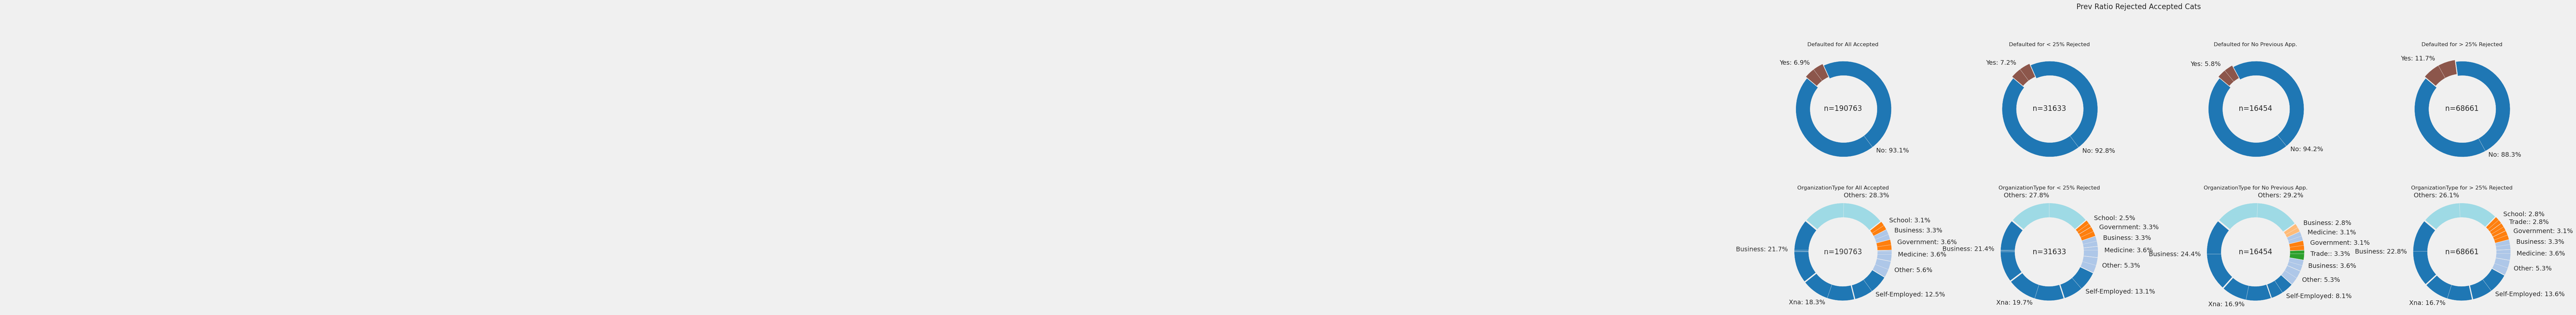

In [66]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_with_bins,
    split_var="PrevRatioRejectedAccepted_cats",
    include_cols=["Defaulted", "OrganizationType"],
)



In [ ]:
features_matrix_with_bins["TotalDefaults_cats"].value_counts()

In [ ]:
features_matrix_with_bins["PrevRatioRejectedAccepted_cats"].value_counts()

Interestingly we can see that while applicants whose previous loans were rejected are significantly more likely to default when finally given a loan previous clients with no failed applications have a higher default risk than new clients.

This likely limits the usefulness of the `previous_application` table because only a small proportion of clients have previously rejected applications

In [ ]:
importlib.reload(graph)
graph.draw_distribution_pie_charts(
    features_matrix_with_bins,
    split_var="TotalDefaults_cats",
    include_cols=["Defaulted", "OrganizationType"],
)



In [ ]:
features_matrix["TotalDefaults"].describe()

In [ ]:
list(features_matrix_with_bins.columns)

In [ ]:
shared_utils.ANY_IMP_FEATURES

In [ ]:
graph.boxen_plots_by_category(
    source_df=features_matrix_with_bins,
    group_col="pass__purpose",
    target_col="pass__loan_amnt",
    title="Loan Amount by Purpose",
    x_label="Loan Amount",
)


In [ ]:
importlib.reload(graph)
for target_y in ["AmtCredit"]:
    for c in ["CodeGender", "DaysEmployed_binned", "NameEducationType", "OccupationType", "OwnCarAge_binned", 
              "DaysBirth_binned", "NameFamilyStatus" 
        , "NameFamilyStatus"]:
    # for c in features_matrix_with_bins.columns:
    #     if pd.api.types.is_numeric_dtype(features_matrix_with_bins[c]):
    #         continue
    #     
    #     for 
        display(graph.boxen_plot_by_cat(c, features_matrix_with_bins, target_y, drop_small_cats=True))
